<a href="https://colab.research.google.com/github/aleks-haksly/Simulative/blob/main/Other/Analysis/%D0%90%D0%BB%D1%8C%D1%84%D0%B0%20%D0%91%D0%B0%D0%BD%D0%BA%20test/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandasql -q

  Preparing metadata (setup.py) ... done


In [237]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%load_ext sql
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## SQL1
Отобрать клиентов по г. Москва с суммарными остатками по клиенту от 20 000 на
последнюю дату.

create table #Клиенты (client_id varchar(1), FIO varchar (255) , Region varchar(50), account_num int)


insert into #Клиенты values
('A','Иванов','Москва',111),
('A','Иванов','Москва',222),
('B','Петров','Иваново',333),
('C','Сидоров','Москва',444)

create table #Cчета ([Date] date, Summa_USD money, Account_num int)


insert into #Cчета values
('2012-01-01',15000,111),
('2012-02-01',10000,111),
('2012-02-01',5000,222),
('2012-03-01',30000,333),
('2012-04-01',20000,444)

### Создадим пустую БД sqlite и добавим туда нужные данные

In [ ]:
%sql sqlite:////content//tempt.db

In [ ]:
%%sql
CREATE TABLE Clients (client_id varchar(1), FIO varchar (255) , Region varchar(50), account_num int);
INSERT INTO Clients (client_id, FIO, Region, account_num) VALUES
    ('A','Иванов','Москва',111),
    ('A','Иванов','Москва',222),
    ('B','Петров','Иваново',333),
    ('C','Сидоров','Москва',444);

 * sqlite:////content//tempt.db
Done.
4 rows affected.


[]

In [ ]:
%%sql
CREATE TABLE Accounts ([Date] date, Summa_USD money, Account_num int);
INSERT INTO Accounts ([Date], Summa_USD, Account_num) VALUES
('2012-01-01',15000,111),
('2012-02-01',10000,111),
('2012-02-01',5000,222),
('2012-03-01',30000,333),
('2012-04-01',20000,444);

 * sqlite:////content//tempt.db
Done.
5 rows affected.


[]

In [ ]:
query = '''
WITH t AS (
SELECT
  s.*,
  c.*,
  sum(Summa_USD) OVER (PARTITION BY c.client_id ORDER BY [Date]) as cum_sum,
  row_number() OVER (partition BY s.Account_num ORDER BY [Date] DESC) as rn
FROM Cчета s
INNER JOIN Clients c
ON
  c.Account_num = s.Account_num
  AND c.region = 'Москва')

SELECT distinct(client_id)
FROM t
WHERE cum_sum >= 20000
AND rn = 1
'''
%sql $query

 * sqlite:////content//tempt.db
Done.


client_id
A
C


In [ ]:
query = '''
SELECT
  c.client_id
FROM Clients c
LEFT JOIN Accounts a
ON a.Account_num = c.Account_num
WHERE c.Region = 'Москва'
GROUP BY c.client_id
HAVING sum(Summa_USD) >= 20000
'''
%sql $query

 * sqlite:////content//tempt.db
Done.


client_id
A
C


## SQL2
Необходимо посчитать кол-во клиентов, у которых баланс на 2023-07-07 больше 500
рублей.

* IN - приход средств на счет клиента,
* OUT - отток.

create table oper (client varchar, date date, type varchar, amount int);

insert into oper values
('a', '2023-06-02', 'in', 1985),

('a', '2023-06-03', 'in', 1577),

('a', '2023-06-04', 'out', 1597),

('b', '2023-06-05', 'in', 1468),

('c', '2023-07-06', 'in', 582),

('c', '2023-07-08', 'out', 550),

('d', '2023-06-09', 'in', 1556),

('d', '2023-06-10', 'out', 1480)

In [ ]:
%%sql
DROP TABLE IF EXISTS oper;
CREATE TABLE oper (client varchar, [date] date, [type] varchar, amount int);
INSERT INTO oper (client, [date], [type], amount) VALUES
('a', '2023-06-02', 'in', 1985),
('a', '2023-06-03', 'in', 1577),
('a', '2023-06-04', 'out', 1597),
('b', '2023-06-05', 'in', 1468),
('c', '2023-07-06', 'in', 582),
('c', '2023-07-08', 'out', 550),
('d', '2023-06-09', 'in', 1556),
('d', '2023-06-10', 'out', 1480);

 * sqlite:////content//tempt.db
Done.
Done.
8 rows affected.


[]

In [ ]:
sql = """
WITH t AS (
SELECT client,
SUM(CASE [type] WHEN 'in' THEN amount ELSE 0-amount END) summ
FROM oper
WHERE [date] <= '2023-07-07'
GROUP BY client
HAVING summ > 500)

SELECT COUNT(client) FROM t
"""
%sql $sql

 * sqlite:////content//tempt.db
Done.


COUNT(client)
3


## 3 SQL

Даны данные о действиях клиента в мобильном приложении. Нужно получить для
 каждого клиента его первое действие и время этого первого действия


 create table events (client varchar, date date, actions varchar);
 insert into events values
 ('a', '2019-06-02', 'Auth'),
 ('a', '2019-06-03', 'Pay'),
 ('a', '2019-06-04', 'Auth'),
 ('b', '2019-06-05', 'Settings'),
 ('b', '2019-06-06', 'Error'),
 ('c', '2019-07-06', 'Chat'),
 ('c', '2019-07-08', 'Pay');

In [140]:
%%sql
DROP TABLE IF EXISTS events;
CREATE TABLE events (client varchar, date date, actions varchar);
INSERT INTO events (client, [date], actions) VALUES
 ('a', '2019-06-02', 'Auth'),
 ('a', '2019-06-03', 'Pay'),
 ('a', '2019-06-04', 'Auth'),
 ('b', '2019-06-05', 'Settings'),
 ('b', '2019-06-06', 'Error'),
 ('c', '2019-07-06', 'Chat'),
 ('c', '2019-07-08', 'Pay');

 * sqlite:////content//tempt.db
Done.
Done.
7 rows affected.


[]

In [148]:
sql = """
SELECT client, actions FROM (
SELECT
  client, actions, row_number() OVER (PARTITION BY client ORDER BY date) as rn
FROM events) t
WHERE t.rn = 1

"""
result = %sql $sql
pd.DataFrame(result)

 * sqlite:////content//tempt.db
Done.


,client,actions
0,a,Auth
1,b,Settings
2,c,Chat


## SQL4* (повышенная сложность, оценивается отдельно)
Даны месячные срезы сегментов
 клиентов, нужно получить по каждому клиенту периоды действия каждого сегмента

 create table #segment ([date] date, ClientID varchar(6),SegmentID int)
 insert into #segment values
 ('2018-01-31' ,'A11111', 2),
 ('2018-02-28' ,'A11111', 2),
 ('2018-03-31' ,'A11111', 1),
 ('2018-04-30' ,'A11111', 2),
 ('2018-05-31' ,'A11111', 1),
 ('2017-11-30' ,'B22222', 1),
 ('2017-10-31' ,'B22222', 1),
 ('2017-09-30' ,'B22222', 3),
 ('2017-09-30' ,'C33333', 1),
 ('2017-10-31' ,'C33333', 1)


In [153]:
%%sql
DROP TABLE IF EXISTS segment;
CREATE TABLE segment ([date] date, ClientID varchar(6), SegmentID int);
INSERT INTO segment ([date], ClientID, SegmentID) VALUES
 ('2018-01-31' ,'A11111', 2),
 ('2018-02-28' ,'A11111', 2),
 ('2018-03-31' ,'A11111', 1),
 ('2018-04-30' ,'A11111', 2),
 ('2018-05-31' ,'A11111', 1),
 ('2017-11-30' ,'B22222', 1),
 ('2017-10-31' ,'B22222', 1),
 ('2017-09-30' ,'B22222', 3),
 ('2017-09-30' ,'C33333', 1),
 ('2017-10-31' ,'C33333', 1);

 * sqlite:////content//tempt.db
Done.
Done.
10 rows affected.


[]

In [161]:
sql = """
SELECT
  ClientID,
  SegmentID,
  min(date) OVER (PARTITION BY SegmentID) as start_date,
  max(date) OVER (PARTITION BY SegmentID) as end_date
FROM segment
GROUP BY ClientID, SegmentID
ORDER BY 1, 2

"""
result = %sql $sql
pd.DataFrame(result)

 * sqlite:////content//tempt.db
Done.


,ClientID,SegmentID,start_date,end_date
0,A11111,1,2017-09-30,2018-03-31
1,A11111,2,2018-01-31,2018-01-31
2,B22222,1,2017-09-30,2018-03-31
3,B22222,3,2017-09-30,2017-09-30
4,C33333,1,2017-09-30,2018-03-31


In [214]:
df = pd.read_csv("https://github.com/aleks-haksly/Simulative/raw/refs/heads/main/Other/Analysis/%D0%90%D0%BB%D1%8C%D1%84%D0%B0%20%D0%91%D0%B0%D0%BD%D0%BA%20test/dataset.zip",
                 compression='zip', sep=';', parse_dates=["VALUE_DAY"], date_format='%d.%m.%Y', usecols=[1, 2])

In [215]:
df

,CLIENT_ID,VALUE_DAY
0,3596869440,2021-09-30
1,181778433,2021-09-30
2,4271531990,2021-09-30
3,3949165697,2021-09-30
4,1926920317,2021-09-30
...,...,...
805816,4243322997,2022-02-28
805817,67461867,2022-02-28
805818,302417315,2022-02-28
805819,1780553365,2022-02-28


In [216]:
df = df.merge(df.groupby("CLIENT_ID")["VALUE_DAY"].min().dt.to_period('M').rename("COHORT"), how='left', on="CLIENT_ID")

In [218]:
df["MONTH_DELTA"] = (df.VALUE_DAY.dt.to_period('M') - df.COHORT).apply(lambda x: x.n)

In [247]:
pivoted = df.pivot_table(index="COHORT", columns='MONTH_DELTA', values='CLIENT_ID', aggfunc='nunique').fillna(0).apply(lambda x: x / x[0], axis=1)

In [248]:
pivoted

MONTH_DELTA,0,1,2,3,4,5
COHORT,,,,,,
2021-09,1.0,0.964103,0.930358,0.901139,0.816725,0.806016
2021-10,1.0,0.984668,0.977144,0.715503,0.681431,0.000000
2021-11,1.0,0.983222,0.894539,0.749358,0.000000,0.000000
2021-12,1.0,0.900073,0.897455,0.000000,0.000000,0.000000
2022-01,1.0,0.973189,0.000000,0.000000,0.000000,0.000000
2022-02,1.0,0.000000,0.000000,0.000000,0.000000,0.000000


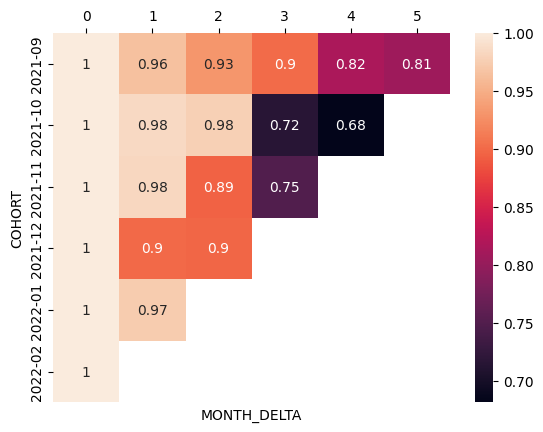

In [249]:
ax = sns.heatmap(pivoted.replace([0.0], [np.NaN]), annot=True, );
ax.xaxis.tick_top()

MONTH_DELTA,0,1,2,3,4,5
COHORT,,,,,,
2021-09,1.0,0.964103,0.930358,0.901139,0.816733,0.806023
2021-10,1.0,0.984668,0.977144,0.715503,0.681431,0.000000
2021-11,1.0,0.983222,0.894539,0.749358,0.000000,0.000000
2021-12,1.0,0.900073,0.897455,0.000000,0.000000,0.000000
2022-01,1.0,0.973189,0.000000,0.000000,0.000000,0.000000
2022-02,1.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
exec_query = lambda query: sqldf(query, env=globals())

In [ ]:
exec_query("SELECT * FROM df where query like '%утро%'")

,platform,hour,query,count
0,desktop,0,доброе утро,1


,REG_DATE
CLIENT_ID,
8294,2021-09
10609,2021-09
15465,2021-09
69014,2021-09
100397,2021-09
...,...
4294839524,2021-09
4294859384,2021-09
4294873964,2021-09
